# Text classificaton with ngrams

This notebook is based on the EDOS dataset and its two versions:

- The original version of the dataset (called `original_df`)
- The balanced version of the dataset (called `balanced_df`)

For each version, we will apply the following technique in order to achieve text binary classification on sexism:

1. Fine-tuning a BERT model on binary classification
2. Using Logistic Regression for binary classification
3. Using cosine similarity between ngrams' embeddings

Before applying any technique, we will perform some data analysis and exploration and some text preprocessing.

# Data analysis and exploration

The goal of this step is to find out if our data is linearly separable and if there are any correlations between its features.

## Class, polarity, subjectivity and embeddings distributions

To better understand the difference between the original dataset and the balanced one, we perform the same data analysis and exploration of both versions.

In [1]:
!pip install -q spacytextblob

In [2]:
import torch

# detect currently used device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
import pandas as pd

# load the original dataset
original_csv = "/kaggle/input/edos-dataset/edos_labelled_aggregated.csv"
original_df = pd.read_csv(original_csv)

# load the balanced dataset
balanced_csv = "hf://datasets/tum-nlp/sexism-socialmedia-balanced/sexism-socialmedia-balanced.csv"
balanced_df = pd.read_csv(balanced_csv)

In [4]:
from string import punctuation
import spacy, string

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.replace("[USER]", "").replace("[URL]", "")
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

# preprocess original dataset text
original_df['clean_text'] = original_df['text'].apply(clean_text)

# preprocess balanced dataset text
balanced_df['clean_text'] = balanced_df['text'].apply(clean_text)

In [5]:
from transformers import BertTokenizer, BertModel
import torch

# load BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_bert_embedding(sentence):
    if pd.isna(sentence):
        return None
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=256).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()
    
# extract text embeddings form the original dataset
original_df['embedding'] = original_df['clean_text'].apply(get_bert_embedding)

# extract text embedding from the balanced dataset
balanced_df['embedding'] = balanced_df['clean_text'].apply(get_bert_embedding)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

# load spacy and spacytextblob
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

def calculate_sentiment(text):
    if pd.isna(text):
        return None, None
    doc = nlp(text)
    polarity = doc._.polarity
    subjectivity = doc._.subjectivity
    return polarity, subjectivity

# compute original dataset sentence polarity and subjectivity
original_df['polarity'], original_df['subjectivity'] = zip(*original_df['clean_text'].apply(calculate_sentiment))
    
# compute balanced dataset sentence polarity and subjectivity
balanced_df['polarity'], balanced_df['subjectivity'] = zip(*balanced_df['clean_text'].apply(calculate_sentiment))

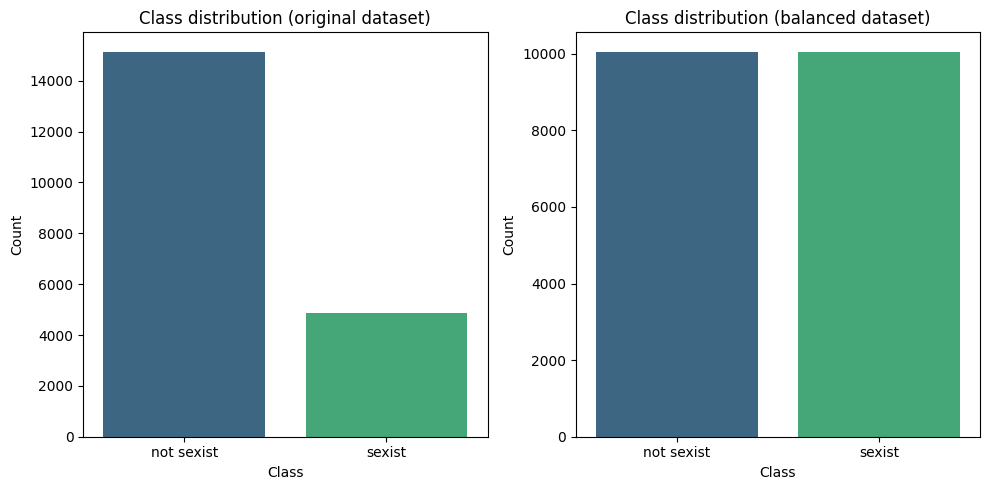

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plot original dataset sentence distribution
sns.countplot(ax=axes[0], x='label_sexist', data=original_df, palette='viridis')
axes[0].set_title('Class distribution (original dataset)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# plot balanced dataset sentence distribution
sns.countplot(ax=axes[1], x='label_sexist', data=balanced_df, palette='viridis')
axes[1].set_title('Class distribution (balanced dataset)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Polarity')

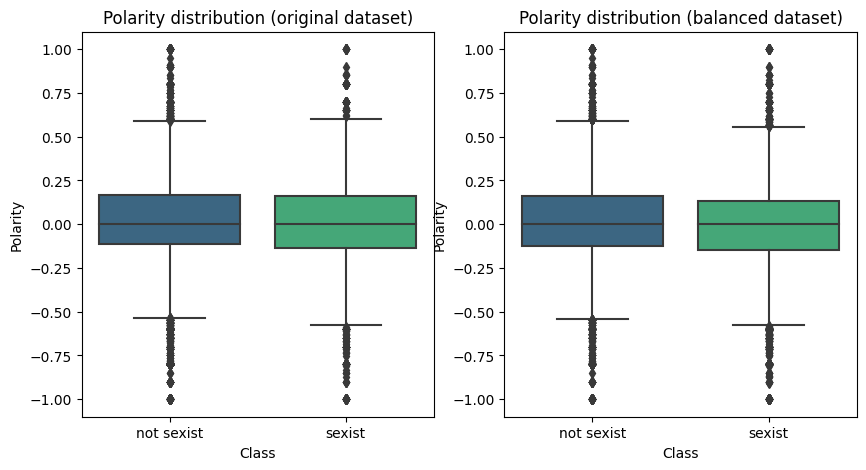

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plot original dataset polarity distribution
sns.boxplot(ax=axes[0], y='polarity', x='label_sexist', data=original_df, palette='viridis')
axes[0].set_title('Polarity distribution (original dataset)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Polarity')

# plot balanced dataset polarity distribution
sns.boxplot(ax=axes[1], y='polarity', x='label_sexist', data=balanced_df, palette='viridis')
axes[1].set_title('Polarity distribution (balanced dataset)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Polarity')

Text(0, 0.5, 'Subjectivity')

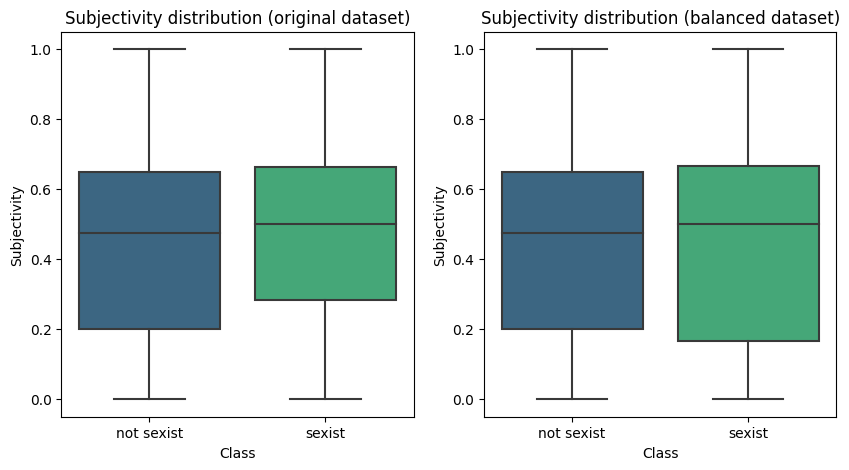

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plot original dataset subjectivity distribution
sns.boxplot(ax=axes[0], x='label_sexist', y='subjectivity', data=original_df, palette='viridis')
axes[0].set_title('Subjectivity distribution (original dataset)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Subjectivity')

# plot balanced dataset subjectivity distribution
sns.boxplot(ax=axes[1], x='label_sexist', y='subjectivity', data=balanced_df, palette='viridis')
axes[1].set_title('Subjectivity distribution (balanced dataset)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Subjectivity')

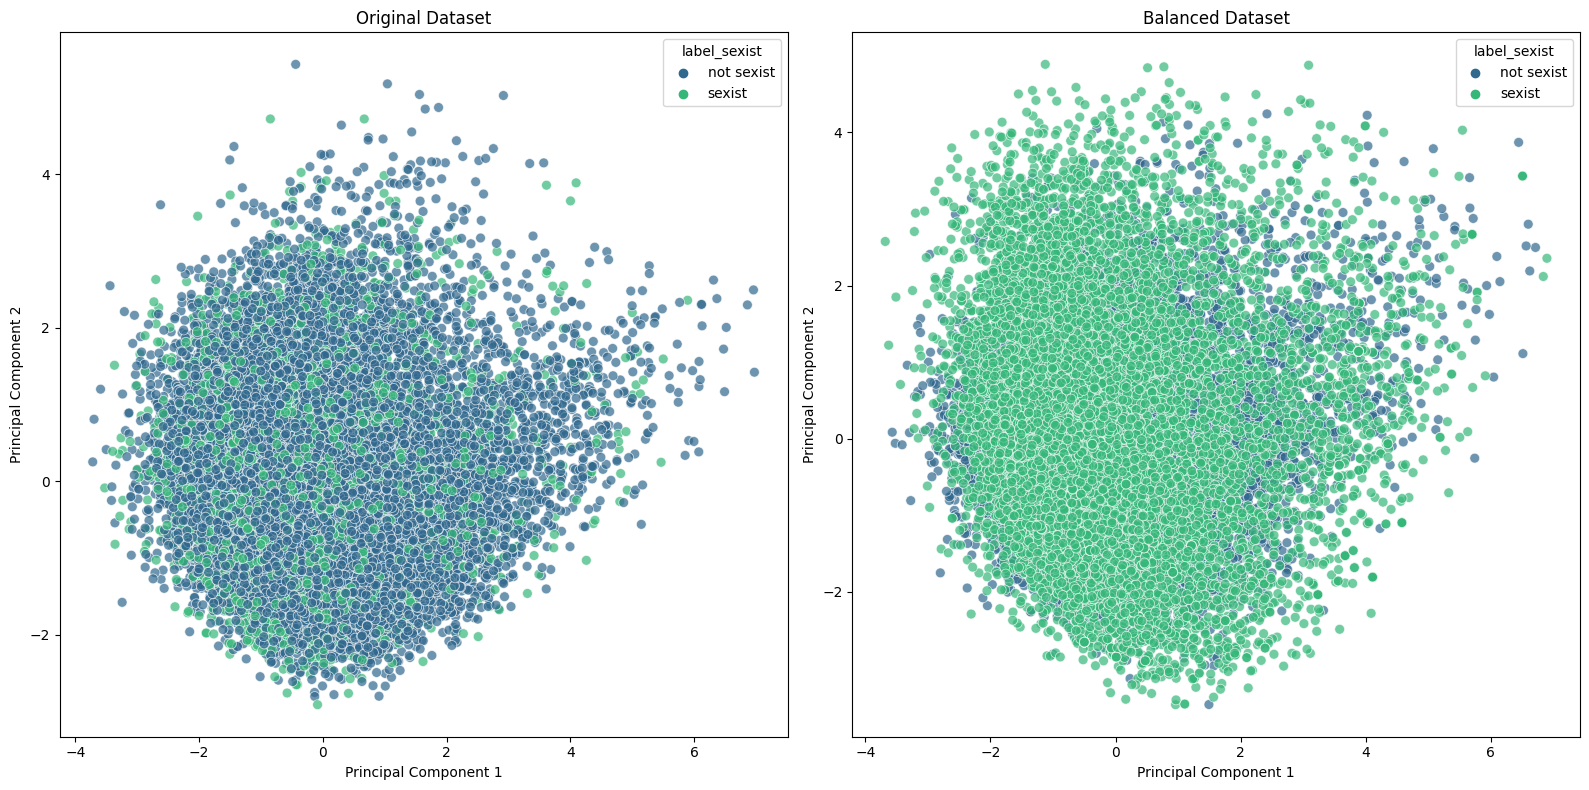

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

def plot_pca_embeddings(df, ax, title):
    pca = PCA(n_components=2)

    embeddings = list(df['embedding'].values)
    embeddings = [emb.detach().cpu().numpy() for emb in embeddings]
    embeddings_pca = pca.fit_transform(embeddings)

    pca_df = pd.DataFrame(embeddings_pca, columns=['PC1', 'PC2'])
    pca_df['label_sexist'] = df['label_sexist']

    sns.scatterplot(x='PC1', y='PC2', hue='label_sexist', data=pca_df, palette='viridis', s=50, alpha=0.7, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend(title='label_sexist', loc='best')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# plot original dataset embeddings distribution
plot_pca_embeddings(original_df, axes[0], 'Original Dataset')

# plot balanced dataset embeddings distribution
plot_pca_embeddings(balanced_df, axes[1], 'Balanced Dataset')

plt.tight_layout()
plt.show()

## Observations

The original dataset **class distribution** is very unbalanced while in the balanced one we have 50% of sexist sentences and 50% of not sexist ones.

Moving to **polarity** values, there is no big difference between sentence polarity of sexist and not sexist sentences, hinting that these sentences are quite similar. We can say the same about the **subjectivity** of the sentences. Polarity and subjectiveness cannot be used to distinguish sexist sentences from not sexist ones.

By plotting every sentence **256-embeddings** obtained from BERT we find out that our data is not linearly separable, so we cannot apply any linear model to solve this problem. That's why we will use Logistic Regression and Transformer-based methods.

# 1. Fine-tuning a BERT model on binary classification

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

# load BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
original_bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
balanced_bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
original_optimizer = AdamW(original_bert_model.parameters(), lr=2e-5)
balanced_optimizer = AdamW(balanced_bert_model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
from torch.utils.data import DataLoader, Dataset

label_map = {"sexist": 1, "not sexist": 0}

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.max_len = 128  # max text length for BERT

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = label_map[self.labels[idx]]  # convert label
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def train_model(model, train_loader, optimizer, loss_fn, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss / len(train_loader)}")
    
def evaluate_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Accuracy: {accuracy}')
    print(classification_report(all_labels, all_predictions))

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# prepare data from original dataset
train_original, test_original = train_test_split(original_df, test_size=0.2, random_state=42)
train_dataset_original = TextDataset(train_original['clean_text'].values, train_original['label_sexist'].values)
train_loader_original = DataLoader(train_dataset_original, batch_size=16, shuffle=True)

# prepare data from balanced dataset
train_balanced, test_balanced = train_test_split(balanced_df, test_size=0.2, random_state=42)
train_dataset_balanced = TextDataset(train_balanced['clean_text'].values, train_balanced['label_sexist'].values)
train_loader_balanced = DataLoader(train_dataset_balanced, batch_size=16, shuffle=True)

In [14]:
# fine-tune the model on the original dataset
train_model(original_bert_model, train_loader_original, original_optimizer, loss_fn, device)

# fine-tune the model on the balanced dataset
train_model(balanced_bert_model, train_loader_balanced, balanced_optimizer, loss_fn, device)

Epoch 1/3 - Loss: 0.3842905378378928
Epoch 2/3 - Loss: 0.2501224880712107
Epoch 3/3 - Loss: 0.12761168120848015
Epoch 1/3 - Loss: 0.4159289883009008
Epoch 2/3 - Loss: 0.2611697592715146
Epoch 3/3 - Loss: 0.13107697836773297


In [15]:
# show training results on the original dataset
test_dataset_original = TextDataset(test_original['clean_text'].values, test_original['label_sexist'].values)
test_loader_original = DataLoader(test_dataset_original, batch_size=16, shuffle=False)

print("Evaluation on original dataset:")
evaluate_model(original_bert_model, test_loader_original, device)

# show training results on the balanced dataset
test_dataset_balanced = TextDataset(test_balanced['clean_text'].values, test_balanced['label_sexist'].values)
test_loader_balanced = DataLoader(test_dataset_balanced, batch_size=16, shuffle=False)

print("Evaluation on balanced dataset:")
evaluate_model(balanced_bert_model, test_loader_balanced, device)

Evaluation on original dataset:
Accuracy: 0.83675
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3045
           1       0.64      0.70      0.67       955

    accuracy                           0.84      4000
   macro avg       0.77      0.79      0.78      4000
weighted avg       0.84      0.84      0.84      4000

Evaluation on balanced dataset:
Accuracy: 0.8605171556439583
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      2005
           1       0.88      0.84      0.86      2017

    accuracy                           0.86      4022
   macro avg       0.86      0.86      0.86      4022
weighted avg       0.86      0.86      0.86      4022



In [16]:
# save original dataset model
torch.save(original_bert_model.state_dict(), 'original_bert_model.pth')
torch.save(original_optimizer.state_dict(), 'original_optimizer.pth')

# save balanced dataset model
torch.save(balanced_bert_model.state_dict(), 'balanced_bert_model.pth')
torch.save(balanced_optimizer.state_dict(), 'balanced_optimizer.pth')

## Results

In [17]:
sentences = [
    "Women are not suited for leadership roles.", # sexist
    "The team worked together to achieve their goals.", # not sexist
    "Go back in the kitchen and make me a sandwich", # sexist
    "Women are better than men", # sexist
    "Woman driving, peril thriving", # sexist
    "Stop talking like a Karen", # sexist
    "If she breaths she's a thot" # sexist
]

inputs = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True).to(device)

with torch.no_grad():
    original_outputs = original_bert_model(**inputs)
    balanced_outputs = balanced_bert_model(**inputs)
    
# try the fine-tuned model on the original dataset
original_predictions = torch.argmax(original_outputs.logits, dim=1).tolist()

# try the fine-tuned model on the balanced dataset
balanced_predictions = torch.argmax(balanced_outputs.logits, dim=1).tolist()

for sentence, orig_pred, bal_pred in zip(sentences, original_predictions, balanced_predictions):
    print(f"Sentence: {sentence}")
    print(f"Original Model Prediction: {'Sexist' if orig_pred == 1 else 'Not Sexist'}")
    print(f"Balanced Model Prediction: {'Sexist' if bal_pred == 1 else 'Not Sexist'}")
    print()

Sentence: Women are not suited for leadership roles.
Original Model Prediction: Sexist
Balanced Model Prediction: Sexist

Sentence: The team worked together to achieve their goals.
Original Model Prediction: Not Sexist
Balanced Model Prediction: Not Sexist

Sentence: Go back in the kitchen and make me a sandwich
Original Model Prediction: Not Sexist
Balanced Model Prediction: Sexist

Sentence: Women are better than men
Original Model Prediction: Sexist
Balanced Model Prediction: Sexist

Sentence: Woman driving, peril thriving
Original Model Prediction: Not Sexist
Balanced Model Prediction: Not Sexist

Sentence: Stop talking like a Karen
Original Model Prediction: Not Sexist
Balanced Model Prediction: Sexist

Sentence: If she breaths she's a thot
Original Model Prediction: Sexist
Balanced Model Prediction: Sexist



# 2. Using Logistic Regression for binary classification

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# initialize tf-idf vectorizer
tfidf = TfidfVectorizer(max_features=5000)

In [19]:
# compute values from the original dataset
X_train_orig = tfidf.fit_transform(train_original['clean_text'])
X_test_orig = tfidf.transform(test_original['clean_text'])

# compute values from the balanced dataset
X_train_bal = tfidf.fit_transform(train_balanced['clean_text'])
X_test_bal = tfidf.transform(test_balanced['clean_text'])

# extract and convert labels
y_train_orig = train_original['label_sexist'].apply(lambda x: 1 if x == 'sexist' else 0)
y_test_orig = test_original['label_sexist'].apply(lambda x: 1 if x == 'sexist' else 0)
y_train_bal = train_balanced['label_sexist'].apply(lambda x: 1 if x == 'sexist' else 0)
y_test_bal = test_balanced['label_sexist'].apply(lambda x: 1 if x == 'sexist' else 0)

In [20]:
from sklearn.linear_model import LogisticRegression

# initialize logistic regression models
log_reg_orig = LogisticRegression(max_iter=1000)
log_reg_bal = LogisticRegression(max_iter=1000)

# train on the original dataset
log_reg_orig.fit(X_train_orig, y_train_orig)

# train on the balanced dataset
log_reg_bal.fit(X_train_bal, y_train_bal)

LogisticRegression(max_iter=1000)

In [21]:
from sklearn.metrics import classification_report

# predictions on the original dataset
y_pred_orig = log_reg_orig.predict(X_test_orig)

# predictions on the balanced dataset
y_pred_bal = log_reg_bal.predict(X_test_bal)

# show training results on the original dataset
print("Classification Report for Original Dataset:")
print(classification_report(y_test_orig, y_pred_orig, target_names=['Not Sexist', 'Sexist']))

# show training results on the balanced dataset
print("Classification Report for Balanced Dataset:")
print(classification_report(y_test_bal, y_pred_bal, target_names=['Not Sexist', 'Sexist']))

Classification Report for Original Dataset:
              precision    recall  f1-score   support

  Not Sexist       0.82      0.97      0.89      3045
      Sexist       0.78      0.34      0.47       955

    accuracy                           0.82      4000
   macro avg       0.80      0.65      0.68      4000
weighted avg       0.81      0.82      0.79      4000

Classification Report for Balanced Dataset:
              precision    recall  f1-score   support

  Not Sexist       0.77      0.87      0.81      2005
      Sexist       0.85      0.74      0.79      2017

    accuracy                           0.80      4022
   macro avg       0.81      0.80      0.80      4022
weighted avg       0.81      0.80      0.80      4022



## Results

In [22]:
# define some sentences to test
sentences = [
    "Women are not suited for leadership roles.", # sexist
    "The team worked together to achieve their goals.", # not sexist
    "Go back in the kitchen and make me a sandwich", # sexist
    "Women are better than men", # sexist
    "Woman driving, peril thriving", # sexist
    "Stop talking like a Karen", # sexist
    "If she breaths she's a thot", # sexist
    "Yesterday I went to the store and I bought a cake" # not sexist
]

# and compute their tf-idf
X_test_sentences = tfidf.transform(sentences)

# try the model based on the original dataset
y_pred_sentences_orig = log_reg_orig.predict(X_test_sentences)

# try the model based on the balanced dataset
y_pred_sentences_bal = log_reg_bal.predict(X_test_sentences)

# convert predictions labels
label_map = {0: 'Not Sexist', 1: 'Sexist'}
y_pred_sentences_orig_labels = [label_map[pred] for pred in y_pred_sentences_orig]
y_pred_sentences_bal_labels = [label_map[pred] for pred in y_pred_sentences_bal]

print("Original model prediction:")
for sentence, label in zip(sentences, y_pred_sentences_orig_labels):
    print(f"'{sentence}' - {label}")

print("\nBalanced model prediction:")
for sentence, label in zip(sentences, y_pred_sentences_bal_labels):
    print(f"'{sentence}' - {label}")

Original model prediction:
'Women are not suited for leadership roles.' - Not Sexist
'The team worked together to achieve their goals.' - Not Sexist
'Go back in the kitchen and make me a sandwich' - Not Sexist
'Women are better than men' - Not Sexist
'Woman driving, peril thriving' - Not Sexist
'Stop talking like a Karen' - Not Sexist
'If she breaths she's a thot' - Not Sexist
'Yesterday I went to the store and I bought a cake' - Not Sexist

Balanced model prediction:
'Women are not suited for leadership roles.' - Sexist
'The team worked together to achieve their goals.' - Not Sexist
'Go back in the kitchen and make me a sandwich' - Sexist
'Women are better than men' - Sexist
'Woman driving, peril thriving' - Sexist
'Stop talking like a Karen' - Not Sexist
'If she breaths she's a thot' - Not Sexist
'Yesterday I went to the store and I bought a cake' - Not Sexist


In [23]:
import joblib

# save both models
joblib.dump(log_reg_orig, 'log_reg_orig_model.pkl')
joblib.dump(log_reg_bal, 'log_reg_bal_model.pkl')

['log_reg_bal_model.pkl']

# 3. Using cosine similarity between ngrams' embeddings

In [24]:
!pip install -q sentence-transformers

In [25]:
from sentence_transformers import SentenceTransformer

# load sentence transformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)

2024-07-15 08:35:14.640342: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 08:35:14.640459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 08:35:14.775111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [26]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# load spacy
nlp = spacy.load("en_core_web_sm")

In [27]:
# train set on the original dataset
train_original_sexist_sentences = train_original[train_original['label_sexist'] == 'sexist']['clean_text'].tolist()
train_original_not_sexist_sentences = train_original[train_original['label_sexist'] == 'not sexist']['clean_text'].tolist()

# train set on the balanced dataset
train_balanced_sexist_sentences = train_balanced[train_balanced['label_sexist'] == 'sexist']['clean_text'].tolist()
train_balanced_not_sexist_sentences = train_balanced[train_balanced['label_sexist'] == 'not sexist']['clean_text'].tolist()

# test set on the original dataset
test_original_sexist_sentences = test_original[test_original['label_sexist'] == 'sexist']['clean_text'].tolist()
test_original_not_sexist_sentences = test_original[test_original['label_sexist'] == 'not sexist']['clean_text'].tolist()

# test set on the balanced dataset
test_balanced_sexist_sentences = test_balanced[test_balanced['label_sexist'] == 'sexist']['clean_text'].tolist()
test_balanced_not_sexist_sentences = test_balanced[test_balanced['label_sexist'] == 'not sexist']['clean_text'].tolist()

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def generate_trigrams(sentence):
    doc = nlp(sentence)
    tokens = [token.text for token in doc]

    trigrams = []
    for i in range(len(tokens) - 2):
        trigram = tokens[i:i+3]
        trigrams.append(" ".join(trigram))

    return trigrams

train_original['ngrams'] = train_original['clean_text'].apply(generate_trigrams)
train_balanced['ngrams'] = train_balanced['clean_text'].apply(generate_trigrams)

test_original['ngrams'] = test_original['clean_text'].apply(generate_trigrams)
test_balanced['ngrams'] = test_balanced['clean_text'].apply(generate_trigrams)

In [29]:
train_original.head()

,rewire_id,text,label_sexist,label_category,label_vector,split,clean_text,embedding,polarity,subjectivity,ngrams
5894,sexism2022_english-4316,Twitch thot caroline [URL],sexist,3. animosity,"3.1 casual use of gendered slurs, profanities,...",train,Twitch thot caroline,"[tensor(0.0276, device='cuda:0'), tensor(0.089...",0.000000,0.000000,[Twitch thot caroline]
3728,sexism2022_english-5503,I think I captured all of this perfectly with ...,sexist,2. derogation,2.2 aggressive and emotive attacks,test,I think I captured all of this perfectly with ...,"[tensor(0.0660, device='cuda:0'), tensor(-0.06...",0.333333,0.400000,"[I think I, think I captured, I captured all, ..."
8958,sexism2022_english-14573,Bill got even and gave her a black eye.,not sexist,none,none,train,Bill got even and gave her a black eye,"[tensor(0.0189, device='cuda:0'), tensor(-0.35...",-0.166667,0.433333,"[Bill got even, got even and, even and gave, a..."
7671,sexism2022_english-13719,"Observation, analysis and deduction are legiti...",not sexist,none,none,train,Observation analysis and deduction are legitim...,"[tensor(0.2070, device='cuda:0'), tensor(0.166...",0.150000,0.441667,"[Observation analysis and, analysis and deduct..."
5999,sexism2022_english-2417,What about nazi roleplaying? Does that fit int...,not sexist,none,none,train,What about nazi roleplaying Does that fit into...,"[tensor(0.3241, device='cuda:0'), tensor(0.299...",0.200000,0.700000,"[What about nazi, about nazi roleplaying, nazi..."


In [30]:
# original dataset
train_original_sexist_ngrams = [item for sublist in train_original[train_original['label_sexist'] == 'sexist']['ngrams'] for item in sublist]
train_original_not_sexist_ngrams = [item for sublist in train_original[train_original['label_sexist'] == 'not sexist']['ngrams'] for item in sublist]

# balanced dataset
train_balanced_sexist_ngrams = [item for sublist in train_balanced[train_balanced['label_sexist'] == 'sexist']['ngrams'] for item in sublist]
train_balanced_not_sexist_ngrams = [item for sublist in train_balanced[train_balanced['label_sexist'] == 'not sexist']['ngrams'] for item in sublist]

In [31]:
# remove common ngrams
set_original_sexist = set(train_original_sexist_ngrams)
set_original_not_sexist = set(train_original_not_sexist_ngrams)

set_balanced_sexist = set(train_balanced_sexist_ngrams)
set_balanced_not_sexist = set(train_balanced_not_sexist_ngrams)

common_ngrams_original = set_original_sexist.intersection(set_original_not_sexist)
common_ngrams_balanced = set_balanced_sexist.intersection(set_balanced_not_sexist)

In [32]:
train_original_sexist_ngrams = list(set_original_sexist - common_ngrams_original)
train_original_not_sexist_ngrams = list(set_original_not_sexist - common_ngrams_original)

train_balanced_sexist_ngrams = list(set_balanced_sexist - common_ngrams_balanced)
train_balanced_not_sexist_ngrams = list(set_balanced_not_sexist - common_ngrams_balanced)

print("Number of ngrams (original):", len(train_original_sexist_ngrams), "+", len(train_original_not_sexist_ngrams))
print("Number of ngrams (balanced):", len(train_balanced_sexist_ngrams), "+", len(train_balanced_not_sexist_ngrams))

Number of ngrams (original): 73634 + 215430
Number of ngrams (balanced): 140028 + 141597


In [33]:
def get_embeddings(texts):
    embeddings = model.encode(texts)
    return embeddings

train_original_sexist_embeddings = get_embeddings(train_original_sexist_ngrams)
train_original_not_sexist_embeddings = get_embeddings(train_original_not_sexist_ngrams)

train_balanced_sexist_embeddings = get_embeddings(train_balanced_sexist_ngrams)
train_balanced_not_sexist_embeddings = get_embeddings(train_balanced_not_sexist_ngrams)

Batches:   0%|          | 0/2302 [00:00<?, ?it/s]

Batches:   0%|          | 0/6733 [00:00<?, ?it/s]

Batches:   0%|          | 0/4376 [00:00<?, ?it/s]

Batches:   0%|          | 0/4425 [00:00<?, ?it/s]

## Results (testing)

In [34]:
# example of input sentence
input_text = "If she breaths she's a thot"

# preprocess text
cleaned_text = clean_text(input_text)

# trigrams extraction
if len(cleaned_text) >= 3:
    trigrams = generate_trigrams(cleaned_text)
else:
    trigrams = []

most_sexist_trigram = None
max_sexist_similarity = -1.0

support = np.zeros(len(trigrams), dtype=int)

# compute trigrams embeddings for the input sentence
if trigrams:
    trigram_embeddings = get_embeddings(trigrams)
    
    for i, (trigram, embedding) in enumerate(zip(trigrams, trigram_embeddings)):
        similarities_sexist = cosine_similarity([embedding], train_original_sexist_embeddings)
        sexist_index = np.argmax(similarities_sexist)
        
        similarities_not_sexist = cosine_similarity([embedding], train_original_not_sexist_embeddings)
        not_sexist_index = np.argmax(similarities_not_sexist)
        
        similarity_on_sexist = similarities_sexist[0][sexist_index]
        similarity_on_not_sexist = similarities_not_sexist[0][not_sexist_index]
        
        print("\nMost similar sexist trigram to\t\t", trigram, "is\t\t", train_original_sexist_ngrams[sexist_index], "\t\twith score:", similarity_on_sexist)
        print("Most similar not sexist trigram to\t", trigram, "is\t\t", train_original_not_sexist_ngrams[not_sexist_index], "\t\twith score:", similarity_on_not_sexist)
        
        if similarity_on_sexist > max_sexist_similarity:
            max_sexist_similarity = similarity_on_sexist
            most_sexist_trigram = trigram
        
        # build support vector
        if similarity_on_sexist > similarity_on_not_sexist:
            support[i] = 1
        else:
            support[i] = 0

    print("\nSupport:", support)
    
    # compute sexism degree
    percentage_sexist = np.count_nonzero(support == 1) / len(support) * 100
    percentage_not_sexist = np.count_nonzero(support == 0) / len(support) * 100

    print(f"\nPercentage of sexist (1): {percentage_sexist:.2f}%")
    print(f"Percentage of not sexist (0): {percentage_not_sexist:.2f}%")

    # compute cosine similarity on sexist and not sexist trigrams 
    similarities_sexist = cosine_similarity(trigram_embeddings, train_original_sexist_embeddings)
    similarities_not_sexist = cosine_similarity(trigram_embeddings, train_original_not_sexist_embeddings)

    # compute global mean
    mean_similarity_sexist = similarities_sexist.mean()
    mean_similarity_not_sexist = similarities_not_sexist.mean()
    
    print("\nSexist similarity mean:", mean_similarity_sexist)
    print("Not sexist similarity mean:", mean_similarity_not_sexist)

    # compute final label
    if mean_similarity_sexist > mean_similarity_not_sexist:
        print(f"\nThe sentence '{input_text}' is {percentage_sexist:.2f}% sexist.")
        print(f"\tPossible detected sexist trigram is: {most_sexist_trigram}")
    else:
        print(f"\nThe sentence '{input_text}' is {percentage_not_sexist:.2f}% not sexist.")

else:
    print(f"\nThe sentence '{input_text}' is too short!.")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Most similar sexist trigram to		 If she breaths is		 If she breathes 		with score: 0.9102977
Most similar not sexist trigram to	 If she breaths is		 breathing she might 		with score: 0.7990049

Most similar sexist trigram to		 she breaths she is		 she calls her 		with score: 0.6646234
Most similar not sexist trigram to	 she breaths she is		 breath she says 		with score: 0.7464378

Most similar sexist trigram to		 breaths she s is		 mouth she s 		with score: 0.67998123
Most similar not sexist trigram to	 breaths she s is		 breath she says 		with score: 0.72201097

Most similar sexist trigram to		 she s a is		 she s A 		with score: 1.0
Most similar not sexist trigram to	 she s a is		 she ’s an 		with score: 0.92406994

Most similar sexist trigram to		 s a thot is		 s a thot 		with score: 1.0000001
Most similar not sexist trigram to	 s a thot is		 “ Thot ” 		with score: 0.80379975

Support: [1 0 0 1 1]

Percentage of sexist (1): 60.00%
Percentage of not sexist (0): 40.00%

Sexist similar

In [35]:
# example of input sentence
input_text = "If she breaths she's a thot"

# preprocess text
cleaned_text = clean_text(input_text)

# trigrams extraction
if len(cleaned_text) >= 3:
    trigrams = generate_trigrams(cleaned_text)
else:
    trigrams = []

most_sexist_trigram = None
max_sexist_similarity = -1.0

support = np.zeros(len(trigrams), dtype=int)

# compute trigrams embeddings for the input sentence
if trigrams:
    trigram_embeddings = get_embeddings(trigrams)
    
    for i, (trigram, embedding) in enumerate(zip(trigrams, trigram_embeddings)):
        similarities_sexist = cosine_similarity([embedding], train_balanced_sexist_embeddings)
        sexist_index = np.argmax(similarities_sexist)
        
        similarities_not_sexist = cosine_similarity([embedding], train_balanced_not_sexist_embeddings)
        not_sexist_index = np.argmax(similarities_not_sexist)
        
        similarity_on_sexist = similarities_sexist[0][sexist_index]
        similarity_on_not_sexist = similarities_not_sexist[0][not_sexist_index]
        
        print("\nMost similar sexist trigram to\t\t", trigram, "is\t\t", train_balanced_sexist_ngrams[sexist_index], "\t\twith score:", similarity_on_sexist)
        print("Most similar not sexist trigram to\t", trigram, "is\t\t", train_balanced_not_sexist_ngrams[not_sexist_index], "\t\twith score:", similarity_on_not_sexist)
        
        if similarity_on_sexist > max_sexist_similarity:
            max_sexist_similarity = similarity_on_sexist
            most_sexist_trigram = trigram
        
        # build support vector
        if similarity_on_sexist > similarity_on_not_sexist:
            support[i] = 1
        else:
            support[i] = 0

    print("\nSupport:", support)
    
    # compute sexism degree
    percentage_sexist = np.count_nonzero(support == 1) / len(support) * 100
    percentage_not_sexist = np.count_nonzero(support == 0) / len(support) * 100

    print(f"\nPercentage of sexist (1): {percentage_sexist:.2f}%")
    print(f"Percentage of not sexist (0): {percentage_not_sexist:.2f}%")

    # compute cosine similarity on sexist and not sexist trigrams 
    similarities_sexist = cosine_similarity(trigram_embeddings, train_balanced_sexist_embeddings)
    similarities_not_sexist = cosine_similarity(trigram_embeddings, train_balanced_not_sexist_embeddings)

    # compute global mean
    mean_similarity_sexist = similarities_sexist.mean()
    mean_similarity_not_sexist = similarities_not_sexist.mean()
    
    print("\nSexist similarity mean:", mean_similarity_sexist)
    print("Not sexist similarity mean:", mean_similarity_not_sexist)

    # final label
    if mean_similarity_sexist > mean_similarity_not_sexist:
        print(f"\nThe sentence '{input_text}' is {percentage_sexist:.2f}% sexist.")
        print(f"\tPossible detected sexist trigram is: {most_sexist_trigram}")
    else:
        print(f"\nThe sentence '{input_text}' is {percentage_not_sexist:.2f}% not sexist.")

else:
    print(f"\nThe sentence '{input_text}' is too short!.")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Most similar sexist trigram to		 If she breaths is		 If she breathe 		with score: 0.9101502
Most similar not sexist trigram to	 If she breaths is		 if she blows 		with score: 0.7619592

Most similar sexist trigram to		 she breaths she is		 she breathe she 		with score: 0.87908936
Most similar not sexist trigram to	 she breaths she is		 breath she says 		with score: 0.74643785

Most similar sexist trigram to		 breaths she s is		 breathe she a 		with score: 0.7437494
Most similar not sexist trigram to	 breaths she s is		 breath she says 		with score: 0.72201097

Most similar sexist trigram to		 she s a is		 she s A 		with score: 1.0
Most similar not sexist trigram to	 she s a is		 she as a 		with score: 0.8351523

Most similar sexist trigram to		 s a thot is		 s a thot 		with score: 1.0000001
Most similar not sexist trigram to	 s a thot is		 Thot is some 		with score: 0.7634035

Support: [1 1 1 1 1]

Percentage of sexist (1): 100.00%
Percentage of not sexist (0): 0.00%

Sexist similarit

## Results (evaluation)

In [36]:
from sklearn.metrics import classification_report

def calculate_classification_report(data):
    ngrams = data['ngrams'].tolist()
    labels = data['label_sexist'].tolist()

    flat_ngrams = [ngram for sublist in ngrams for ngram in sublist]

    trigram_embeddings = get_embeddings(flat_ngrams)

    start = 0
    trigram_embeddings_per_sentence = []
    for sublist in ngrams:
        end = start + len(sublist)
        trigram_embeddings_per_sentence.append(trigram_embeddings[start:end])
        start = end

    predictions = np.zeros(len(data), dtype=int)

    for i, embeddings in enumerate(trigram_embeddings_per_sentence):
        if len(embeddings) == 0:
            predictions[i] = 0  # sexist if no trigrams
            continue

        similarities_sexist = cosine_similarity(embeddings, train_balanced_sexist_embeddings)
        similarities_not_sexist = cosine_similarity(embeddings, train_balanced_not_sexist_embeddings)

        mean_similarity_sexist = similarities_sexist.mean()
        mean_similarity_not_sexist = similarities_not_sexist.mean()

        if mean_similarity_sexist > mean_similarity_not_sexist:
            predictions[i] = 1  # sexist
        else:
            predictions[i] = 0  # not sexist

    labels = [1 if label == 'sexist' else 0 for label in labels]
    report = classification_report(labels, predictions, target_names=['not sexist', 'sexist'])

    return report

# test on original dataset
classification_report_original = calculate_classification_report(test_original)
print("Classification Report for Original Dataset:")
print(classification_report_original)

# test on balanced dataset
classification_report_balanced = calculate_classification_report(test_balanced)
print("\nClassification Report for Balanced Dataset:")
print(classification_report_balanced)


Batches:   0%|          | 0/2781 [00:00<?, ?it/s]

Classification Report for Original Dataset:
              precision    recall  f1-score   support

  not sexist       0.96      0.06      0.11      3045
      sexist       0.25      0.99      0.40       955

    accuracy                           0.28      4000
   macro avg       0.61      0.53      0.25      4000
weighted avg       0.79      0.28      0.18      4000



Batches:   0%|          | 0/2702 [00:00<?, ?it/s]


Classification Report for Balanced Dataset:
              precision    recall  f1-score   support

  not sexist       0.88      0.06      0.11      2005
      sexist       0.51      0.99      0.68      2017

    accuracy                           0.53      4022
   macro avg       0.69      0.53      0.39      4022
weighted avg       0.69      0.53      0.40      4022



## Results (sentences)

In [37]:
sentences = [
    "Women are not suited for leadership roles.", # sexist
    "The team worked together to achieve their goals.", # not sexist
    "Go back in the kitchen and make me a sandwich", # sexist
    "Women are better than men", # sexist
    "Woman driving, peril thriving", # sexist
    "Stop talking like a Karen", # sexist
    "If she breaths she's a thot", # sexist
    "Yesterday I went to the store and I bought a cake" # not sexist
]

for input_text in sentences:
    cleaned_text = clean_text(input_text)

    if len(cleaned_text) >= 3:
        trigrams = generate_trigrams(cleaned_text)
    else:
        trigrams = []

    most_sexist_trigram = None
    max_sexist_similarity = -1.0

    support = np.zeros(len(trigrams), dtype=int)

    if trigrams:
        trigram_embeddings = get_embeddings(trigrams)

        for i, (trigram, embedding) in enumerate(zip(trigrams, trigram_embeddings)):
            similarities_sexist = cosine_similarity([embedding], train_original_sexist_embeddings)
            sexist_index = np.argmax(similarities_sexist)

            similarities_not_sexist = cosine_similarity([embedding], train_original_not_sexist_embeddings)
            not_sexist_index = np.argmax(similarities_not_sexist)

            similarity_on_sexist = similarities_sexist[0][sexist_index]
            similarity_on_not_sexist = similarities_not_sexist[0][not_sexist_index]

            if similarity_on_sexist > max_sexist_similarity:
                max_sexist_similarity = similarity_on_sexist
                most_sexist_trigram = trigram

            if similarity_on_sexist > similarity_on_not_sexist:
                support[i] = 1
            else:
                support[i] = 0

        percentage_sexist = np.count_nonzero(support == 1) / len(support) * 100
        percentage_not_sexist = np.count_nonzero(support == 0) / len(support) * 100

        similarities_sexist = cosine_similarity(trigram_embeddings, train_original_sexist_embeddings)
        similarities_not_sexist = cosine_similarity(trigram_embeddings, train_original_not_sexist_embeddings)

        mean_similarity_sexist = similarities_sexist.mean()
        mean_similarity_not_sexist = similarities_not_sexist.mean()

        if mean_similarity_sexist > mean_similarity_not_sexist:
            print(f"\nThe sentence '{input_text}' is {percentage_sexist:.2f}% sexist.")
            print(f"\tPossible detected sexist trigram is: {most_sexist_trigram}")
        else:
            print(f"\nThe sentence '{input_text}' is {percentage_not_sexist:.2f}% not sexist.")

    else:
        print(f"\nThe sentence '{input_text}' is too short!.")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'Women are not suited for leadership roles.' is 100.00% sexist.
	Possible detected sexist trigram is: Women are not


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'The team worked together to achieve their goals.' is 0.00% sexist.
	Possible detected sexist trigram is: to achieve their


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'Go back in the kitchen and make me a sandwich' is 62.50% sexist.
	Possible detected sexist trigram is: Go back in


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'Women are better than men' is 0.00% sexist.
	Possible detected sexist trigram is: better than men


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'Woman driving, peril thriving' is 0.00% sexist.
	Possible detected sexist trigram is: Woman driving peril


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'Stop talking like a Karen' is 33.33% sexist.
	Possible detected sexist trigram is: talking like a


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'If she breaths she's a thot' is 60.00% sexist.
	Possible detected sexist trigram is: s a thot


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'Yesterday I went to the store and I bought a cake' is 100.00% not sexist.


In [38]:
sentences = [
    "Women are not suited for leadership roles.", # sexist
    "The team worked together to achieve their goals.", # not sexist
    "Go back in the kitchen and make me a sandwich", # sexist
    "Women are better than men", # sexist
    "Woman driving, peril thriving", # sexist
    "Stop talking like a Karen", # sexist
    "If she breaths she's a thot", # sexist
    "Yesterday I went to the store and I bought a cake" # not sexist
]

for input_text in sentences:
    cleaned_text = clean_text(input_text)

    if len(cleaned_text) >= 3:
        trigrams = generate_trigrams(cleaned_text)
    else:
        trigrams = []

    most_sexist_trigram = None
    max_sexist_similarity = -1.0

    support = np.zeros(len(trigrams), dtype=int)

    if trigrams:
        trigram_embeddings = get_embeddings(trigrams)

        for i, (trigram, embedding) in enumerate(zip(trigrams, trigram_embeddings)):
            similarities_sexist = cosine_similarity([embedding], train_balanced_sexist_embeddings)
            sexist_index = np.argmax(similarities_sexist)

            similarities_not_sexist = cosine_similarity([embedding], train_balanced_not_sexist_embeddings)
            not_sexist_index = np.argmax(similarities_not_sexist)

            similarity_on_sexist = similarities_sexist[0][sexist_index]
            similarity_on_not_sexist = similarities_not_sexist[0][not_sexist_index]

            if similarity_on_sexist > max_sexist_similarity:
                max_sexist_similarity = similarity_on_sexist
                most_sexist_trigram = trigram

            if similarity_on_sexist > similarity_on_not_sexist:
                support[i] = 1
            else:
                support[i] = 0

        percentage_sexist = np.count_nonzero(support == 1) / len(support) * 100
        percentage_not_sexist = np.count_nonzero(support == 0) / len(support) * 100

        similarities_sexist = cosine_similarity(trigram_embeddings, train_balanced_sexist_embeddings)
        similarities_not_sexist = cosine_similarity(trigram_embeddings, train_balanced_not_sexist_embeddings)

        mean_similarity_sexist = similarities_sexist.mean()
        mean_similarity_not_sexist = similarities_not_sexist.mean()

        if mean_similarity_sexist > mean_similarity_not_sexist:
            print(f"\nThe sentence '{input_text}' is {percentage_sexist:.2f}% sexist.")
            print(f"\tPossible detected sexist trigram is: {most_sexist_trigram}")
        else:
            print(f"\nThe sentence '{input_text}' is {percentage_not_sexist:.2f}% not sexist.")

    else:
        print(f"\nThe sentence '{input_text}' is too short!.")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'Women are not suited for leadership roles.' is 80.00% sexist.
	Possible detected sexist trigram is: Women are not


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'The team worked together to achieve their goals.' is 50.00% sexist.
	Possible detected sexist trigram is: to achieve their


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'Go back in the kitchen and make me a sandwich' is 75.00% sexist.
	Possible detected sexist trigram is: in the kitchen


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'Women are better than men' is 66.67% sexist.
	Possible detected sexist trigram is: better than men


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'Woman driving, peril thriving' is 50.00% sexist.
	Possible detected sexist trigram is: Woman driving peril


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'Stop talking like a Karen' is 33.33% sexist.
	Possible detected sexist trigram is: talking like a


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'If she breaths she's a thot' is 100.00% sexist.
	Possible detected sexist trigram is: s a thot


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


The sentence 'Yesterday I went to the store and I bought a cake' is 66.67% sexist.
	Possible detected sexist trigram is: went to the
